<a href="https://colab.research.google.com/github/rvthx/bachelorarbeit-cropandweed/blob/main/Endg%C3%BCltiges_Modell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup and Top-Layer Training

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from keras import callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.metrics import CategoricalAccuracy, FalseNegatives, FalsePositives, TrueNegatives, TruePositives

In [ ]:
print(np.__version__, pd.__version__, tf.__version__, tfds.__version__, hub.__version__, matplotlib.__version__)

1.22.4 1.5.3 2.12.0 4.9.2 0.13.0 3.7.1


In [ ]:
# Global Variables
RAW_IMG_SIZE = (256, 256)
IMG_SIZE = (224, 224)
IMG_SIZE_SINGLE = 224
IMG_SIZE_RAW_SINGLE = 256
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)
BATCH_SIZE = 32
STOPPING_PATIENCE = 10
LR_PATIENCE = 5
INITIAL_LR = 0.00001
NUM_CLASSES = 9
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8]
CLASS_NAMES = ['Chinee Apple',
               'Lantana',
               'Parkinsonia',
               'Parthenium',
               'Prickly Acacia',
               'Rubber Vine',
               'Siam Weed',
               'Snake Weed',
               'Negatives']

METRICS = [CategoricalAccuracy(name = "categorical_accuracy"), FalseNegatives (name = "FN" ), FalsePositives(name = "FP"), TrueNegatives(name = "TN"), TruePositives(name = "TP")]

In [ ]:
(ds_train_raw, ds_valid_raw, ds_test_raw), ds_info = tfds.load('Deep_weeds', split=['train[0%:60%]', 'train[60%:80%]', 'train[80%:]'], shuffle_files=True, with_info = True, as_supervised = True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/17509 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/deep_weeds/3.0.0.incompleteMBCW5B/deep_weeds-train.tfrecord*...:   0%|    …

Dataset deep_weeds downloaded and prepared to /root/tensorflow_datasets/deep_weeds/3.0.0. Subsequent calls will reuse this data.


In [ ]:
# For checking label counts,
def get_value_counts(ds):
    label_list = []
    for images, labels in ds:
        label_list.append(labels.numpy())
    label_counts = pd.Series(label_list).value_counts(sort=True)

    print(label_counts)

In [ ]:
get_value_counts(ds_train_raw)

8    5514
6     645
0     644
1     644
3     636
2     616
4     614
5     597
7     595
dtype: int64


In [ ]:
get_value_counts(ds_valid_raw)

8    1821
0     247
4     231
5     212
6     211
1     209
2     202
7     186
3     183
dtype: int64


In [ ]:
get_value_counts(ds_test_raw)

8    1771
7     235
0     234
6     218
4     217
2     213
1     211
3     203
5     200
dtype: int64


In [ ]:
def one_hot_encode(image, label):
    label = tf.one_hot(label, NUM_CLASSES)
    return image, label

In [ ]:
## ds_train_raw.map IF CENTERCROP IS USED
ds_train = ds_train_raw.map(one_hot_encode)
ds_valid = ds_valid_raw.map(one_hot_encode)
ds_test = ds_test_raw.map(one_hot_encode)

In [ ]:
data_augmentation = keras.Sequential([
        layers.RandomZoom(height_factor = (-0.5, 0),fill_mode = "constant"),
        layers.RandomFlip(mode = "horizontal_and_vertical"),
        layers.RandomRotation(1),
        layers.RandomBrightness([-0.25, 0.25]),
        layers.CenterCrop(IMG_SIZE_SINGLE, IMG_SIZE_SINGLE) ## IF USED DO NOT FORGET TO MAKE DATASET CHANGES AND ALSO EXCLUDE THE RESIZE CODEBLOCK
    ])

In [ ]:
ds_train = ds_train.batch(batch_size=BATCH_SIZE,
                          drop_remainder=True).prefetch(tf.data.AUTOTUNE)

ds_valid = ds_valid.batch(batch_size=BATCH_SIZE,
                      drop_remainder=True).prefetch(tf.data.AUTOTUNE)

ds_test = ds_test.batch(batch_size=BATCH_SIZE,
                        drop_remainder=True).prefetch(tf.data.AUTOTUNE)

In [ ]:
base_model = keras.applications.ResNet50(
                            include_top=False, # Exclude ImageNet classifier at the top.
                            weights="imagenet",
                            input_shape=(IMG_SIZE_SINGLE, IMG_SIZE_SINGLE, 3)
                            )
base_model.trainable = False

94765736/94765736 [==============================] - 0s 0us/step


In [ ]:
## USE IMAGE_RAW_SINGLE IF CENTERCROP IS USED
inputs = keras.Input(shape=(IMG_SIZE_RAW_SINGLE, IMG_SIZE_RAW_SINGLE, 3))
x = data_augmentation(inputs)

In [ ]:
x = keras.applications.resnet50.preprocess_input(x)

In [ ]:
x = base_model(x, training=True)

In [ ]:
x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(NUM_CLASSES, activation="sigmoid", name="pred", kernel_initializer = tf.keras.initializers.GlorotNormal(seed=64))(x)

model = keras.Model(inputs, outputs)

In [ ]:
model.summary(show_trainable=True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 sequential (Sequential)     (None, 224, 224, 3)       0         Y          
                                                                            
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         Y          
 licingOpLambda)                                                            
                                                                            
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         Y          
                                                                            
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  N          
                                                             

In [ ]:
model_checkpoint = ModelCheckpoint("[FINAL]DeepWeeds_Resnet_TopOnly_Sigmoid_(CenterCrop)BestWeights.hdf5", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(patience=STOPPING_PATIENCE, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau('val_loss', factor=0.5, patience=LR_PATIENCE, min_lr=0.000003125)

callbacks = [model_checkpoint, early_stopping, reduce_lr]

In [ ]:
model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(), metrics=METRICS)

In [ ]:
history = model.fit(ds_train, validation_data = ds_valid, epochs = 50, callbacks = callbacks, verbose = 1)

Epoch 1/50
328/328 [==============================] - ETA: 0s - loss: 0.1996 - categorical_accuracy: 0.6440 - FN: 5286.0000 - FP: 2084.0000 - TN: 81884.0000 - TP: 5210.0000
Epoch 1: val_loss improved from inf to 0.15846, saving model to [FINAL]DeepWeeds_Resnet_TopOnly_Sigmoid_(CenterCrop)BestWeights.hdf5
328/328 [==============================] - 32s 62ms/step - loss: 0.1996 - categorical_accuracy: 0.6440 - FN: 5286.0000 - FP: 2084.0000 - TN: 81884.0000 - TP: 5210.0000 - val_loss: 0.1585 - val_categorical_accuracy: 0.7337 - val_FN: 1637.0000 - val_FP: 361.0000 - val_TN: 27543.0000 - val_TP: 1851.0000 - lr: 0.0010
Epoch 2/50
328/328 [==============================] - ETA: 0s - loss: 0.1475 - categorical_accuracy: 0.7485 - FN: 3909.0000 - FP: 1548.0000 - TN: 82420.0000 - TP: 6587.0000
Epoch 2: val_loss improved from 0.15846 to 0.15128, saving model to [FINAL]DeepWeeds_Resnet_TopOnly_Sigmoid_(CenterCrop)BestWeights.hdf5
328/328 [==============================] - 22s 67ms/step - loss: 0.14

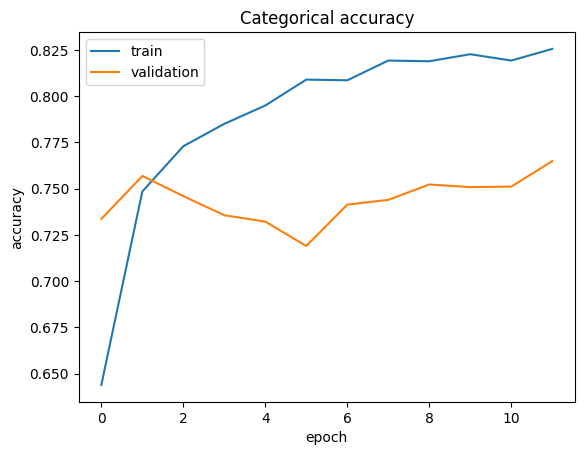

In [ ]:
def plot_hist(hist):
    plt.plot(hist.history['categorical_accuracy'])
    plt.plot(hist.history['val_categorical_accuracy'])
    plt.title('Categorical accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

plot_hist(history)

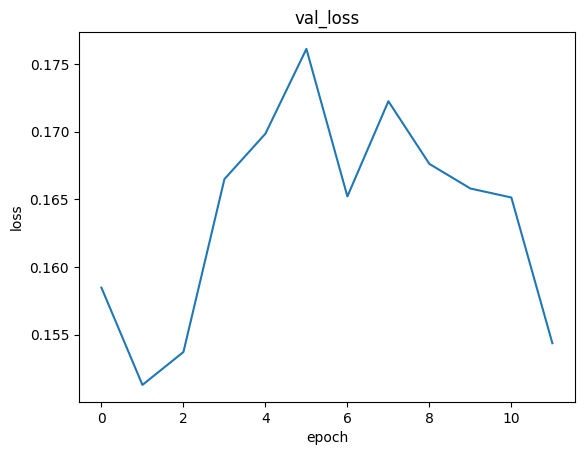

In [ ]:
def plot_hist_loss(hist):
    plt.plot(hist.history['val_loss'])
    plt.title('val_loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()

plot_hist_loss(history)

In [ ]:
result = model.evaluate(ds_test)

109/109 [==============================] - 5s 48ms/step - loss: 0.1581 - categorical_accuracy: 0.7357 - FN: 1588.0000 - FP: 401.0000 - TN: 27503.0000 - TP: 1900.0000


# Full-Training and Evaluation

In [ ]:
model.layers[4].trainable = True

In [ ]:
model.layers[4].summary(show_trainable = True)

Model: "resnet50"
_____________________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     Trainable  
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               Y          
                                )]                                                                           
                                                                                                             
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                Y          
                                                                                                             
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              Y          
                                )                                                                     

In [ ]:
model.summary(show_trainable = True)

Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         Y          
                                                                            
 sequential (Sequential)     (None, 224, 224, 3)       0         Y          
                                                                            
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         Y          
 licingOpLambda)                                                            
                                                                            
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         Y          
                                                                            
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  Y          
                                                             

In [ ]:
model.compile(loss='binary_crossentropy', optimizer = keras.optimizers.Adam(learning_rate = INITIAL_LR), metrics=['categorical_accuracy'])

In [ ]:
history = model.fit(ds_train, validation_data = ds_valid, epochs = 50, callbacks = callbacks, verbose = 1)

Epoch 1/50
328/328 [==============================] - ETA: 0s - loss: 0.1585 - categorical_accuracy: 0.7282
Epoch 1: val_loss improved from 0.15128 to 0.12924, saving model to [FINAL]DeepWeeds_Resnet_TopOnly_Sigmoid_(CenterCrop)BestWeights.hdf5
328/328 [==============================] - 84s 131ms/step - loss: 0.1585 - categorical_accuracy: 0.7282 - val_loss: 0.1292 - val_categorical_accuracy: 0.7775 - lr: 1.0000e-05
Epoch 2/50
328/328 [==============================] - ETA: 0s - loss: 0.1204 - categorical_accuracy: 0.7995
Epoch 2: val_loss improved from 0.12924 to 0.11088, saving model to [FINAL]DeepWeeds_Resnet_TopOnly_Sigmoid_(CenterCrop)BestWeights.hdf5
328/328 [==============================] - 46s 141ms/step - loss: 0.1204 - categorical_accuracy: 0.7995 - val_loss: 0.1109 - val_categorical_accuracy: 0.8179 - lr: 1.0000e-05
Epoch 3/50
328/328 [==============================] - ETA: 0s - loss: 0.1041 - categorical_accuracy: 0.8302
Epoch 3: val_loss improved from 0.11088 to 0.09775, 

In [ ]:
result = model.evaluate(ds_test)

109/109 [==============================] - 5s 46ms/step - loss: 0.0538 - categorical_accuracy: 0.9232


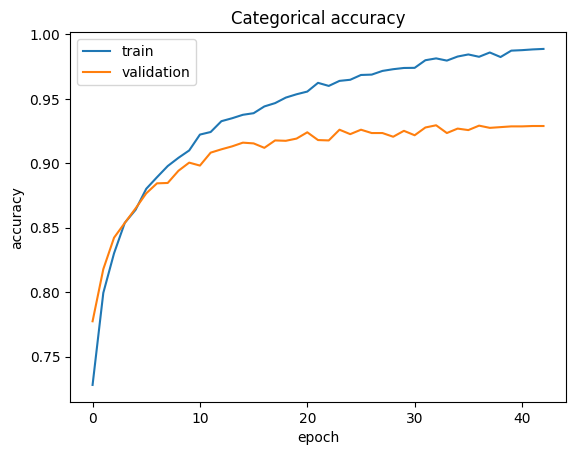

In [ ]:
plot_hist(history)

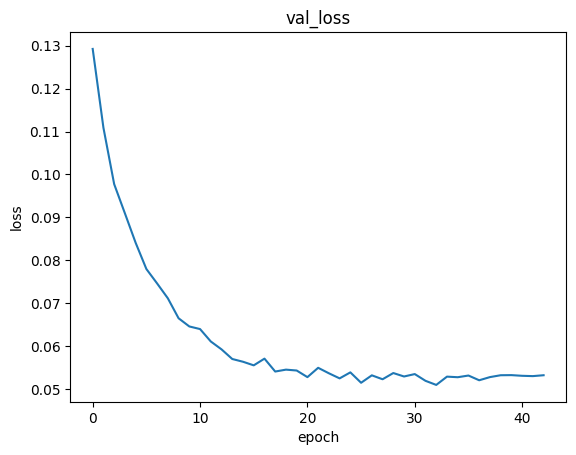

In [ ]:
plot_hist_loss(history)

# Classification Report & Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

In [ ]:
ds_test_labels = []
ds_test_inputs = []
ds_test_unbatch = ds_test.unbatch()
for x,y in ds_test_unbatch.as_numpy_iterator():
  ds_test_inputs.append(x)
  ds_test_labels.append(y)

In [ ]:
np.array(ds_test_inputs).shape

(3488, 256, 256, 3)

In [ ]:
pred = model.predict(ds_test)

109/109 [==============================] - 7s 51ms/step


In [ ]:
predzi = np.argmax(pred, axis=1)

In [ ]:
ds_label_aaa = np.argmax(ds_test_labels, axis=1)

In [ ]:
print(classification_report(ds_label_aaa, predzi, labels=CLASSES, target_names=CLASS_NAMES))

                precision    recall  f1-score   support

  Chinee Apple       0.92      0.74      0.82       234
       Lantana       0.91      0.91      0.91       211
   Parkinsonia       0.94      0.92      0.93       213
    Parthenium       0.91      0.94      0.92       203
Prickly Acacia       0.88      0.89      0.88       217
   Rubber Vine       0.96      0.88      0.92       199
     Siam Weed       0.94      0.92      0.93       216
    Snake Weed       0.89      0.85      0.87       233
     Negatives       0.93      0.97      0.95      1762

      accuracy                           0.92      3488
     macro avg       0.92      0.89      0.90      3488
  weighted avg       0.92      0.92      0.92      3488



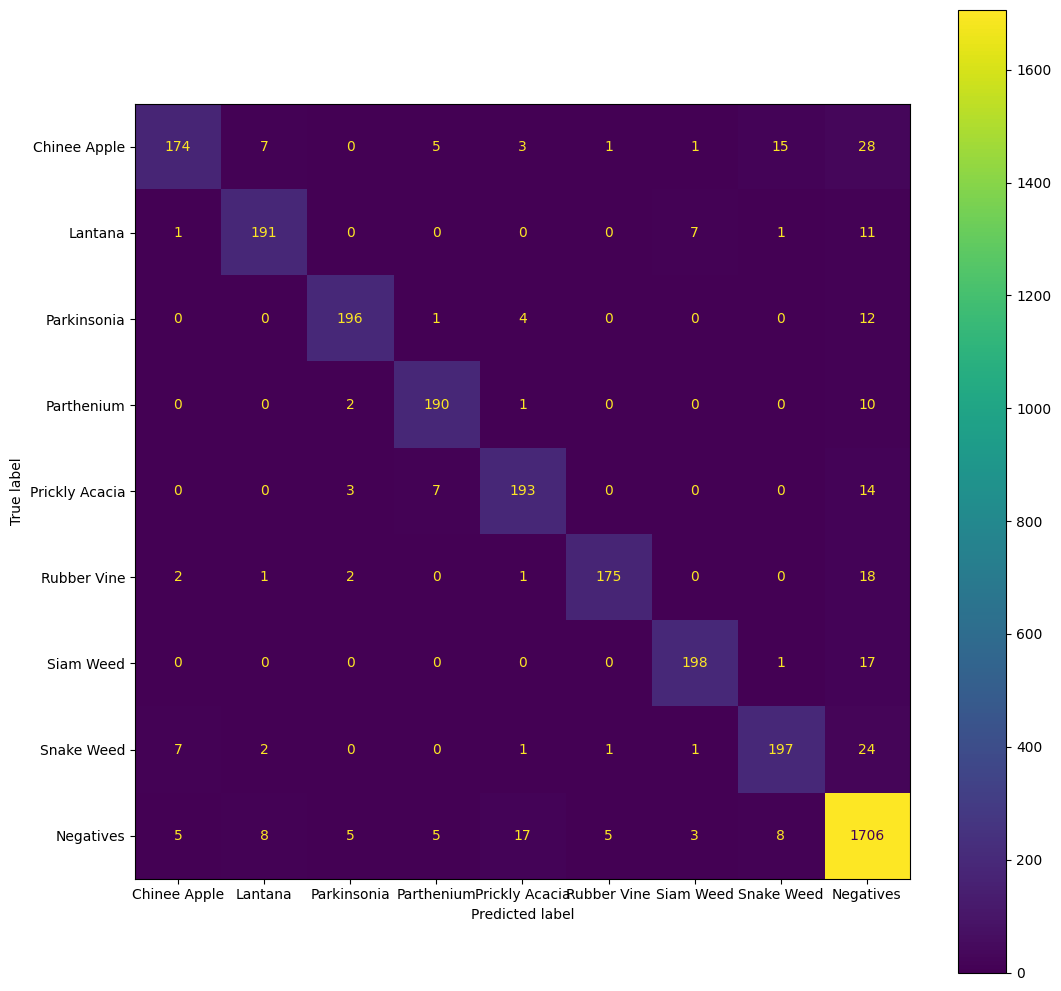

In [ ]:
fig, ax = plt.subplots(figsize=(12.5, 12.5))
ConfusionMatrixDisplay.from_predictions(ds_label_aaa, predzi, ax = ax, display_labels = CLASS_NAMES)